In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Y7553pQQrnzzWlDXUd8V")
project = rf.workspace("mochoye").project("license-plate-detector-ogxxg")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.87, to fix: `pip install ultralytics==8.0.196`


In [3]:
print(f"Dataset path: {dataset.location}")

Dataset path: /content/License-Plate-Detector-2


In [4]:
# Path to the dataset directory
dataset_path = '/content/License-Plate-Detector-2'

# Set the batch size, which determines the number of samples that will be propagated through the network at once
batch_size = 32

# Define the target width and height for resizing the images
img_width = 64
img_height = 64

# Load and preprocess the training dataset from the directory
train_dataset = image_dataset_from_directory(
    dataset_path,                  # Directory containing the dataset
    image_size=(img_height, img_width),  # Resize images to the target size (64x64)
    batch_size=batch_size,          # Number of samples per batch
    label_mode='categorical',       # Labels are returned as one-hot encoded vectors for multi-class classification
    shuffle=True,                   # Shuffle the dataset to prevent the model from learning the order of the samples
    color_mode='rgb',               # Load images in RGB color format (3 channels)
    subset='training',              # Define this subset as the training data
    validation_split=0.2,           # Split 20% of the dataset for validation, leaving 80% for training
    seed=42                         # Set the random seed for reproducibility of the shuffle and split
)

# Load and preprocess the validation dataset from the directory
validation_dataset = image_dataset_from_directory(
    dataset_path,                   # Same directory for the dataset
    image_size=(img_height, img_width),  # Same image size
    batch_size=batch_size,          # Same batch size
    label_mode='categorical',       # Same label format (one-hot encoded)
    shuffle=True,                   # Shuffle the dataset (usually unnecessary for validation, but included here)
    color_mode='rgb',               # Same color mode
    subset='validation',            # Define this subset as the validation data
    validation_split=0.2,           # Same split, but selecting the validation subset
    seed=42                         # Same random seed for consistency
)


Found 395 files belonging to 3 classes.
Using 316 files for training.
Found 395 files belonging to 3 classes.
Using 79 files for validation.


In [5]:
# Data augmentation pipeline to enhance the training dataset with randomized transformations
data_augmentation = Sequential([
    RandomFlip("horizontal"),   # Randomly flip images horizontally (left to right)
    RandomRotation(0.1),        # Randomly rotate images by up to 10% of 360 degrees
    RandomZoom(0.1),            # Randomly zoom into the image by up to 10%
    Rescaling(1./255)  # Normalize pixel values to [0, 1]
])

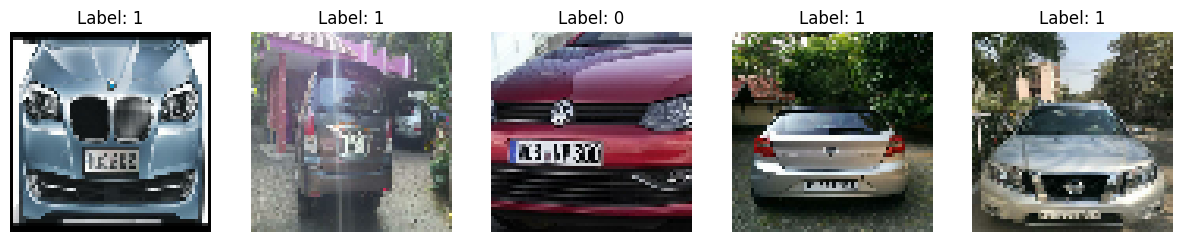

In [6]:
# Visualize sample images from the dataset
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):  # Get one batch of images and labels
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            image = images[i].numpy()
            ax.imshow(image.astype(np.uint8))
            ax.axis('off')
            plt.title(f'Label: {np.argmax(labels[i].numpy())}')
    plt.show()

visualize_samples(train_dataset)


### The Model

In [7]:
!pip install ultralytics

In [8]:
from ultralytics import YOLO

In [9]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/License-Plate-Detector-2/data.yaml epochs=1

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/License-Plate-Detector-2/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

### Two ways for evaluation the model

In [10]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/License-Plate-Detector-2/data.yaml

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 803, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 145, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 297, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 857, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 784, in torch_safe_load
    ckpt = torch.load(fi

In [12]:
# Load the model
model = YOLO('/content/runs/detect/train4/weights/best.pt')

# Evaluate the model
results = model.val(data='/content/License-Plate-Detector-2/data.yaml')

# Print the results
print("Results Summary:")
print(f"mAP: {results.maps[0]}")  # Mean Average Precision for the first IoU threshold (0.5)
print(f"Precision: {results.box.p}") # Access precision using results.box.p
print(f"Recall: {results.box.r}") # Access recall using results.box.r

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/License-Plate-Detector-2/valid/labels.cache... 81 images, 0 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:17<00:00, 12.98s/it]


                   all         81         81      0.807      0.929       0.89      0.654
Speed: 13.3ms preprocess, 931.7ms inference, 0.0ms loss, 7.2ms postprocess per image
Results saved to runs/detect/val
Results Summary:
mAP: 0.654351027896049
Precision: [    0.80704]
Recall: [    0.92944]


### Demo

In [21]:
!yolo predict model=/content/runs/detect/train4/weights/best.pt source='/content/original image.jpg'

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/original image.jpg: 640x480 1 LicensePlate, 517.7ms
Speed: 4.8ms preprocess, 517.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [20]:
!yolo predict model=/content/runs/detect/train4/weights/best.pt source='/content/original car.mp4'

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

video 1/1 (frame 1/127) /content/original car.mp4: 640x384 (no detections), 433.5ms
video 1/1 (frame 2/127) /content/original car.mp4: 640x384 (no detections), 414.2ms
video 1/1 (frame 3/127) /content/original car.mp4: 640x384 (no detections), 391.9ms
video 1/1 (frame 4/127) /content/original car.mp4: 640x384 (no detections), 387.1ms
video 1/1 (frame 5/127) /content/original car.mp4: 640x384 (no detections), 397.8ms
video 1/1 (frame 6/127) /content/original car.mp4: 640x384 (no detections), 406.5ms
video 1/1 (frame 7/127) /content/original car.mp4: 640x384 (no detections), 380.9ms
video 1/1 (frame 8/127) /content/original car.mp4: 640x384 (no detections), 418.2ms
video 1/1 (frame 9/127) /content/original car.mp4: 640x384 (no detections), 402.9ms
video 1/1 (frame 10/127) /content/original car.mp4: 640x384 (no detections),

### Visualization

Training Data Sample Visualization:


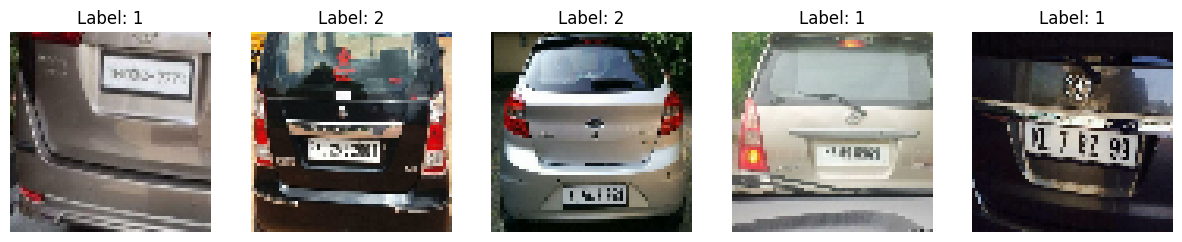

Validation Data Sample Visualization:


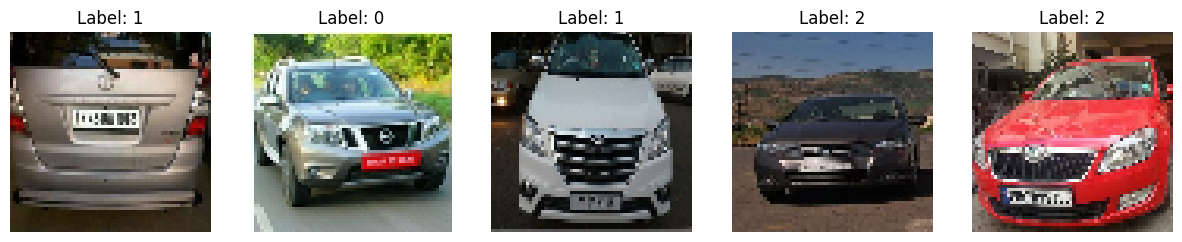

In [15]:
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):  # Get one batch of images and labels
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            image = images[i].numpy()
            ax.imshow(image.astype(np.uint8))
            ax.axis('off')
            plt.title(f'Label: {np.argmax(labels[i].numpy())}')
    plt.show()

print("Training Data Sample Visualization:")
visualize_samples(train_dataset)

print("Validation Data Sample Visualization:")
visualize_samples(validation_dataset)